In [2]:
import pandas as pd
import seaborn as  sns
import matplotlib.pyplot as plt
import  numpy as np

In [300]:
dataset = pd.read_csv("/kaggle/input/kdsh-dataset/btc_6h.csv")
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5959 entries, 0 to 5958
Data columns (total 6 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   datetime  5959 non-null   object 
 1   open      5959 non-null   float64
 2   high      5959 non-null   float64
 3   low       5959 non-null   float64
 4   close     5959 non-null   float64
 5   volume    5959 non-null   float64
dtypes: float64(5), object(1)
memory usage: 279.5+ KB


In [4]:
dataset.head(20)

,datetime,open,high,low,close,volume
0,2018-01-01 05:30:00,13715.65,13715.65,13400.01,13556.15,123.616013
1,2018-01-01 05:45:00,13533.75,13550.87,13402.00,13521.12,98.136430
2,2018-01-01 06:00:00,13500.00,13545.37,13450.00,13470.41,79.904037
3,2018-01-01 06:15:00,13494.65,13690.87,13450.00,13529.01,141.699719
4,2018-01-01 06:30:00,13528.99,13571.74,13402.28,13445.63,72.537533
5,2018-01-01 06:45:00,13469.99,13595.89,13445.63,13560.00,87.861758
6,2018-01-01 07:00:00,13559.99,13559.99,13430.00,13440.01,74.368405
7,2018-01-01 07:15:00,13440.01,13440.01,13155.38,13203.06,148.929310
8,2018-01-01 07:30:00,13203.00,13411.76,13202.03,13387.00,108.542470
9,2018-01-01 07:45:00,13387.00,13388.00,13225.00,13225.00,95.186039


# Data-Preprocessing Feature Selection

In [301]:
dataset['datetime'] = pd.to_datetime(dataset['datetime'])

In [22]:
corr = dataset.copy()

#seperating date time to check dependence on day and hour 
corr['day_of_week'] = corr['datetime'].dt.dayofweek  # Monday is 0, Sunday is 6
corr['hour_of_day'] = corr['datetime'].dt.hour
corr.drop("datetime",axis=1, inplace=True)

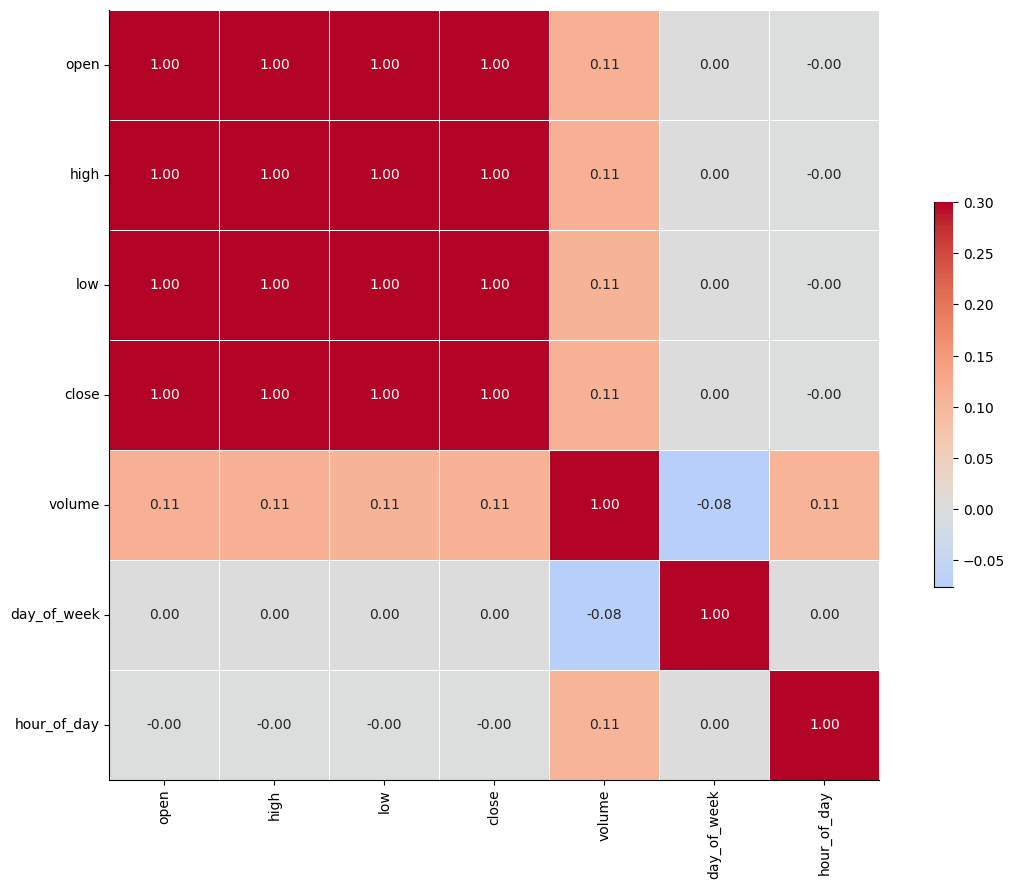

In [23]:
corr =corr.corr()
g = sns.heatmap(corr,  vmax=.3, center=0, square=True, linewidths=.5, cbar_kws={"shrink": .5}, annot=True, fmt='.2f', cmap='coolwarm')
sns.despine()
g.figure.set_size_inches(14,10)

plt.show()


Note :  by this  we can  conclude that volume, day of week and hour of day do not affect open, high, low, close columns 

<Axes: >

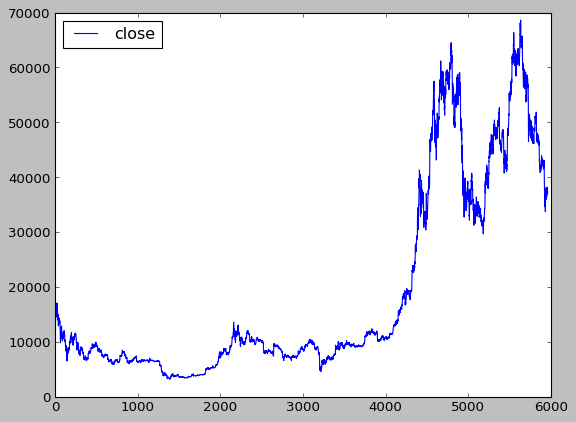

In [124]:
dataset.plot.line(y="close", use_index=True)

# Target Identification and Model Selection

In [302]:
df2 = dataset.copy()
df2["next_value"]= df2["close"].shift(-1)
df2 = df2.iloc[:-1]

In [303]:
# Import necessary libraries
from sklearn.model_selection import train_test_split
from lightgbm import LGBMRegressor
from xgboost import XGBRegressor
from catboost import CatBoostRegressor
import matplotlib.pyplot as plt
import pandas as pd
from keras.models import Sequential
from keras.layers import LSTM,Input,Conv1D,Dense,Flatten
from sklearn.metrics import mean_absolute_error
plt.style.use("_classic_test_patch")
train_df = df2.copy()

**LightGBM regressor**

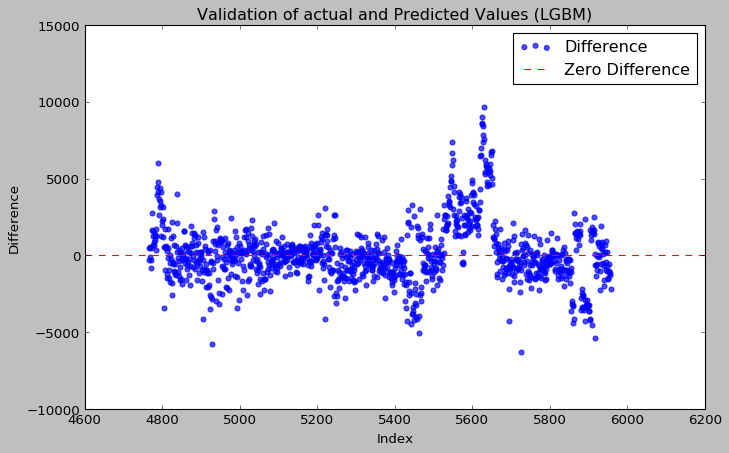

In [127]:

# Assuming you have a datetime column in your DataFrame named 'timestamp'
train_size = int(len(train_df) * 0.8)
train, test = train_df[:train_size], train_df[train_size:]

# Separate features (X) and target variable (y) for training set
X_train = train[['open', 'high', 'low', 'volume', 'close']]
y_train = train[['next_value']]

# Separate features (X) and target variable (y) for testing set
X_test = test[['open', 'high', 'low', 'volume', 'close']]
y_test = test[['next_value']]

# Initialize the LGBMRegressor model
model = LGBMRegressor()

# Train the model
model.fit(X_train, y_train)

# Select the same features from the test set as used for training
X_test_selected = X_test[['open', 'high', 'low', 'volume', 'close']]
results_df = pd.DataFrame({"Actual": y_test['next_value'], "Predicted": model.predict(X_test_selected) })

# Add a column for the differences between actual and predicted values
results_df["Difference"] = results_df["Actual"] - results_df["Predicted"]

# Plot the differences
plt.figure(figsize=(10, 6))
plt.scatter(results_df.index, results_df["Difference"], color='blue', alpha=0.7, label='Difference')
plt.axhline(y=0, color='red', linestyle='--', label='Zero Difference')

# Customize the plot
plt.title('Validation of actual and Predicted Values (LGBM)')
plt.xlabel('Index')
plt.ylabel('Difference')
plt.legend()
plt.show()

**XgBoost Regressor**

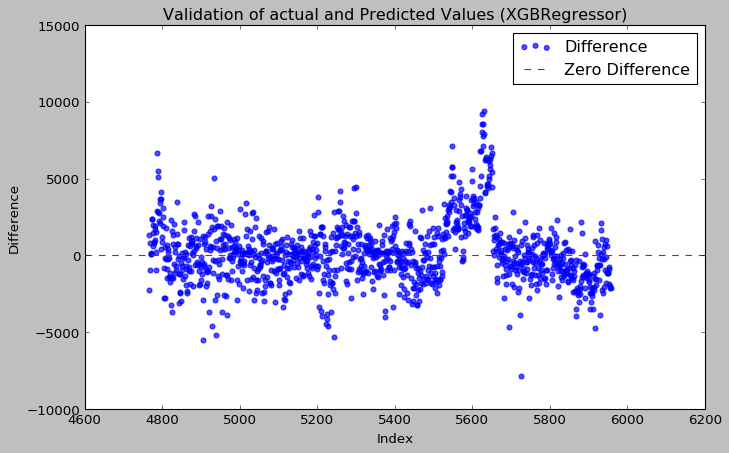

In [129]:
train_size = int(len(train_df) * 0.8)
train, test = train_df[:train_size], train_df[train_size:]

# Separate features (X) and target variable (y) for training set
X_train = train[['open', 'high', 'low', 'volume', 'close']]
y_train = train[['next_value']]

# Separate features (X) and target variable (y) for testing set
X_test = test[['open', 'high', 'low', 'volume', 'close']]
y_test = test[['next_value']]

# Initialize the XGBRegressor model
model = XGBRegressor()

# Train the model
model.fit(X_train, y_train)

# Select the same features from the test set as used for training
X_test_selected = X_test[['open', 'high', 'low', 'volume', 'close']]
results_df = pd.DataFrame({"Actual": y_test['next_value'], "Predicted": model.predict(X_test_selected) })

# Add a column for the differences between actual and predicted values
results_df["Difference"] = results_df["Actual"] - results_df["Predicted"]

# Plot the differences
plt.figure(figsize=(10, 6))
plt.scatter(results_df.index, results_df["Difference"], color='blue', alpha=0.7, label='Difference')
plt.axhline(y=0, color='red', linestyle='--', label='Zero Difference')

# Customize the plot
plt.title('Validation of actual and Predicted Values (XGBRegressor)')
plt.xlabel('Index')
plt.ylabel('Difference')
plt.legend()
plt.show()


Learning rate set to 0.0524
0:	learn: 10604.2398586	total: 57.7ms	remaining: 57.7s
100:	learn: 473.0902161	total: 253ms	remaining: 2.25s
200:	learn: 414.5928485	total: 462ms	remaining: 1.83s
300:	learn: 380.9878761	total: 677ms	remaining: 1.57s
400:	learn: 357.2958136	total: 895ms	remaining: 1.34s
500:	learn: 340.4567415	total: 1.11s	remaining: 1.1s
600:	learn: 324.3576225	total: 1.32s	remaining: 878ms
700:	learn: 311.1107125	total: 1.53s	remaining: 653ms
800:	learn: 299.9896632	total: 1.74s	remaining: 432ms
900:	learn: 290.2420279	total: 1.94s	remaining: 213ms
999:	learn: 280.6113059	total: 2.15s	remaining: 0us


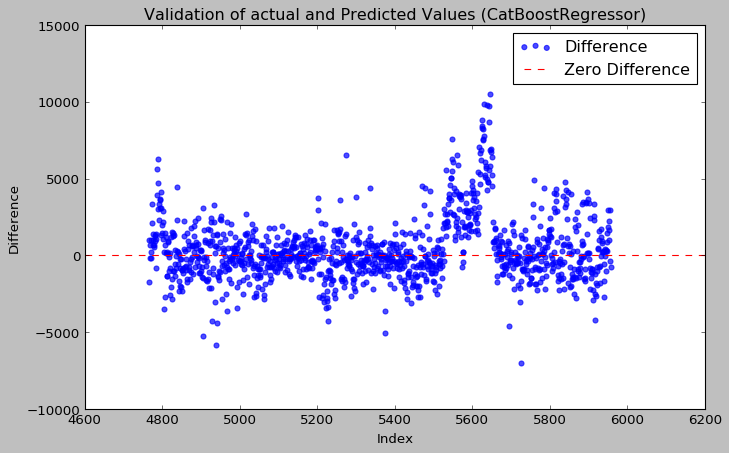

In [130]:
# Assuming you have a datetime column in your DataFrame named 'timestamp'
train_size = int(len(train_df) * 0.8)
train, test = train_df[:train_size], train_df[train_size:]

# Separate features (X) and target variable (y) for training set
X_train = train[['open', 'high', 'low', 'volume', 'close']]
y_train = train[['next_value']]

# Separate features (X) and target variable (y) for testing set
X_test = test[['open', 'high', 'low', 'volume', 'close']]
y_test = test[['next_value']]

# Initialize the CatBoost Regressor model
model =CatBoostRegressor(verbose=100)

# Train the model
model.fit(X_train, y_train)

# Select the same features from the test set as used for training
X_test_selected = X_test[['open', 'high', 'low', 'volume', 'close']]
results_df = pd.DataFrame({"Actual": y_test['next_value'], "Predicted": model.predict(X_test_selected) })

# Add a column for the differences between actual and predicted values
results_df["Difference"] = results_df["Actual"] - results_df["Predicted"]

# Plot the differences
plt.figure(figsize=(10, 6))
plt.scatter(results_df.index, results_df["Difference"], color='blue', alpha=0.7, label='Difference')
plt.axhline(y=0, color='red', linestyle='--', label='Zero Difference')

# Customize the plot
plt.title('Validation of actual and Predicted Values (CatBoostRegressor)')
plt.xlabel('Index')
plt.ylabel('Difference')
plt.legend()
plt.show()


In [304]:
# Import necessary libraries
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
import pandas as pd
from keras.models import Sequential
from keras.layers import LSTM,Input,Conv1D,Dense,Flatten


def train_test(df):
    
    X = df[['open','high','low','volume','close']].values
    y = df['next_value'].values
    
    X_reshaped = X.reshape(X.shape[0], X.shape[1], 1)
    
    return X,y,X_reshaped

def train_test_reshaped(df,size):
    
    X = df[['open','high','low','volume','close']].values
    y = df['next_value'].values
    
    X_reshaped = X.reshape(X.shape[0], X.shape[1], 1)
    
    X_reshaped_train,y_train,X_reshaped_test,y_test = X_reshaped[:size],y[:size],X_reshaped[size:],y[size:]
    
    return X_reshaped_train,y_train,X_reshaped_test,y_test


from keras.models import Sequential
from keras.layers import Input, Conv1D, MaxPooling2D, Flatten, Dense,MaxPool2D,LSTM,Dropout,MaxPooling1D
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint

X,y,X_reshaped = train_test(train_df)

model = Sequential([
         Conv1D(filters=10, kernel_size=3, activation="relu", input_shape=(5,1)),
         Conv1D(filters=10, kernel_size=2, activation="relu"),
         Conv1D(filters=10, kernel_size=1, activation="relu"),
         Flatten(),
         Dense(1, activation="linear")
    ])
model.compile(loss='mse', optimizer='adam', metrics=['mae'])
train_size = int(len(train_df) * 0.8)


X_train,y_train,X_test,y_test = train_test_reshaped(train_df,train_size)
model.fit(X_train,y_train,epochs=75)

Epoch 1/75
149/149 [==============================] - 1s 2ms/step - loss: 21726912.0000 - mae: 2146.2239
Epoch 2/75
149/149 [==============================] - 0s 2ms/step - loss: 359250.0625 - mae: 348.9682
Epoch 3/75
149/149 [==============================] - 0s 2ms/step - loss: 204268.9844 - mae: 234.9991
Epoch 4/75
149/149 [==============================] - 0s 2ms/step - loss: 198776.1406 - mae: 219.2635
Epoch 5/75
149/149 [==============================] - 0s 2ms/step - loss: 201241.7500 - mae: 229.0483
Epoch 6/75
149/149 [==============================] - 0s 2ms/step - loss: 195196.2031 - mae: 214.8792
Epoch 7/75
149/149 [==============================] - 0s 2ms/step - loss: 191723.7969 - mae: 213.6152
Epoch 8/75
149/149 [==============================] - 0s 2ms/step - loss: 197782.7656 - mae: 219.7959
Epoch 9/75
149/149 [==============================] - 0s 2ms/step - loss: 198236.6875 - mae: 218.0323
Epoch 10/75
149/149 [==============================] - 0s 2ms/step - loss: 2060

38/38 [==============================] - 0s 2ms/step


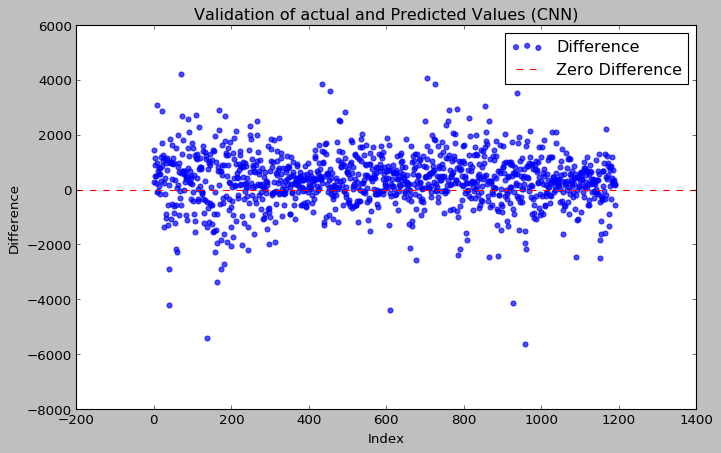

In [305]:
predictions = model.predict(X_test)
results_df = pd.DataFrame({"Actual": y_test, "Predicted": model.predict(X_test)[:,0] })

# Add a column for the differences between actual and predicted values
results_df["Difference"] = results_df["Actual"] - results_df["Predicted"]

# Plot the differences
plt.figure(figsize=(10, 6))
plt.scatter(results_df.index, results_df["Difference"], color='blue', alpha=0.7, label='Difference')
plt.axhline(y=0, color='red', linestyle='--', label='Zero Difference')

# Customize the plot
plt.title('Validation of actual and Predicted Values (CNN)')
plt.xlabel('Index')
plt.ylabel('Difference')
plt.legend()
plt.show()

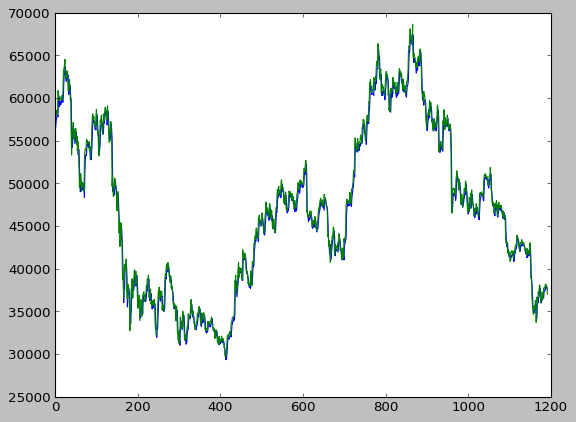

In [306]:
plt.plot(predictions)
plt.plot(y_test)

In [307]:
X, y, X_reshaped = train_test(train_df)
model.fit(X_reshaped, y, epochs = 50, validation_split = 0.2)

Epoch 1/50
149/149 [==============================] - 1s 4ms/step - loss: 176786.6406 - mae: 207.4941 - val_loss: 967993.7500 - val_mae: 702.5461
Epoch 2/50
149/149 [==============================] - 0s 3ms/step - loss: 179546.4219 - mae: 215.1921 - val_loss: 1516676.3750 - val_mae: 940.7479
Epoch 3/50
149/149 [==============================] - 0s 3ms/step - loss: 174584.5469 - mae: 209.6303 - val_loss: 1203328.3750 - val_mae: 843.1857
Epoch 4/50
149/149 [==============================] - 0s 3ms/step - loss: 203757.7500 - mae: 246.2830 - val_loss: 1091673.0000 - val_mae: 749.6716
Epoch 5/50
149/149 [==============================] - 0s 3ms/step - loss: 164327.6250 - mae: 196.6848 - val_loss: 1267142.8750 - val_mae: 827.0334
Epoch 6/50
149/149 [==============================] - 0s 3ms/step - loss: 176936.7344 - mae: 216.2670 - val_loss: 1135499.0000 - val_mae: 805.8009
Epoch 7/50
149/149 [==============================] - 0s 3ms/step - loss: 197901.1719 - mae: 237.6547 - val_loss: 17282

In [308]:
error = mean_absolute_error(model.predict(X_test)[:,0],y_test)
print(f"mean absolute error is : {error}")

38/38 [==============================] - 0s 1ms/step
mean absolute error is : 688.2727356858222


# Creating Trading Strategy and Backtesting

In [3]:
sample_data1 = pd.read_csv("/kaggle/input/sample/out-of-sample-6hr-data-1.csv")
sample_data2 = pd.read_csv("/kaggle/input/sample/out-of-sample-6hr-data-2.csv")

sample_data = pd.concat([sample_data1, sample_data2], ignore_index = True)

In [4]:
sample_data["next_value"]= sample_data["close"].shift(-1)

In [5]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from keras.models import load_model

def train_test(df): #converting sample data to usable form as required by Model
    X = df[['open','high','low','volume','close']].values
    y = df['next_value'].values
    X_reshaped = X.reshape(X.shape[0], X.shape[1], 1)
    return X, y, X_reshaped

model = load_model("/kaggle/input/best-model/best_model_1.h5")

X,y,X_reshaped = train_test(sample_data)

pred = model.predict(X_reshaped)

88/88 [==============================] - 0s 1ms/step


**Concatenating Predictions**

In [6]:
sample_data["predictions"] = pred
sample_data["DateTime"] = pd.to_datetime(sample_data["Date_Time"])
sample_data.drop("Date_Time", axis = 1, inplace = True)

In [10]:
#Initializing variables for trading strategy
historical_data = sample_data.copy()
total_trades, winning_trades, profit, loss, max_profit, max_loss = 0, 0, 0, 0, 0, 0
initial_virtual_capital = 100000 
virtual_capital = initial_virtual_capital
position = 0  
stop_loss_percentage = 0.09
returns = []
peak = 0
selling_price = 0
buy_points = []
sell_points = []
transaction_cost = 0.0015
dip = []
hold = []
historical_data["rolling50"] = historical_data['close'].rolling(window = 50).mean()
historical_data["rolling200"] = historical_data['close'].rolling(window = 200).mean()

In [11]:
def sell(selling_price, buying_price):
    global total_trades, winning_trades, loss, profit, max_profit, max_loss, virtual_capital
    total_trades += 1
    selling_price -= selling_price * transaction_cost
    if (selling_price > buying_price): #selling on Profit
        max_profit = max(max_profit, selling_price - buying_price)
        profit += selling_price - buying_price
        winning_trades += 1
    else: #selling on Loss/Breakeven
        max_loss = max(max_loss, buying_price - selling_price)
        loss += buying_price - selling_price
        dip.append((buying_price - selling_price) / buying_price)
    virtual_capital += selling_price
    sell_points.append((historical_data.iloc[index]['DateTime'], selling_price))
    hold.append((historical_data.iloc[index]['DateTime'] - buying_date).days)
    position = 0
    return position

# Simulate trading decision based on the prediction
for index in range(0, len(historical_data)):
    # Extract features for the current time step
    rolling_mean_50 = historical_data.iloc[index]['rolling50']
    rolling_mean_200 = historical_data.iloc[index]['rolling200']
    
    daily_return = (virtual_capital + position * historical_data.iloc[index]['close'] - initial_virtual_capital) / initial_virtual_capital #capturing daily held investment
    returns.append(daily_return)
    
    if position == 1: #trade held, finding best time to sell
        selling_price = historical_data.iloc[index]['close']
        peak = max(peak, historical_data.iloc[index]['close'])
        
        if historical_data.iloc[index]['predictions'] > selling_price: #if the prediction for the next interval is higher than current close price we will hold
            continue
            
        if (historical_data.iloc[index]['predictions'] <= stop_loss_price): # Sell due to stop-loss
            position = sell(selling_price, buying_price)
            continue

        if rolling_mean_50 < rolling_mean_200: #sell due to bullish condition
            position = sell(selling_price, buying_price)
            continue
            
        
        if ((peak / buying_price) > 1.05) and (((peak - historical_data.iloc[index]['predictions']) / peak) > 0.031): #selling if dropping below 3% of the peak acheived 
            position = sell(selling_price, buying_price)
            continue


   
    elif ((historical_data.iloc[index]["predictions"] > historical_data.iloc[index]["close"] * 1.008 and 
          historical_data.iloc[index]["close"] <= historical_data.iloc[index - 1]["close"] or 
          rolling_mean_50 > rolling_mean_200) and
          virtual_capital >  historical_data.iloc[index]["close"]): #buy if market is expected to rise, with higher prediction price but lower price than previous interval
        buying_date = historical_data.iloc[index]['DateTime']
        peak = historical_data.iloc[index]['close']
        buy_points.append((buying_date, historical_data.iloc[index]['close']))
        position = 1
        buying_price = historical_data.iloc[index]['close']
        buying_price += buying_price * transaction_cost
        virtual_capital -= buying_price
        stop_loss_price = buying_price * (1 - stop_loss_percentage)
       
    
    # Calculate daily return

# Calculate final portfolio value
if position == 1:
    virtual_capital += historical_data.loc[len(historical_data) - 1,'close']
    
final_portfolio_value = virtual_capital

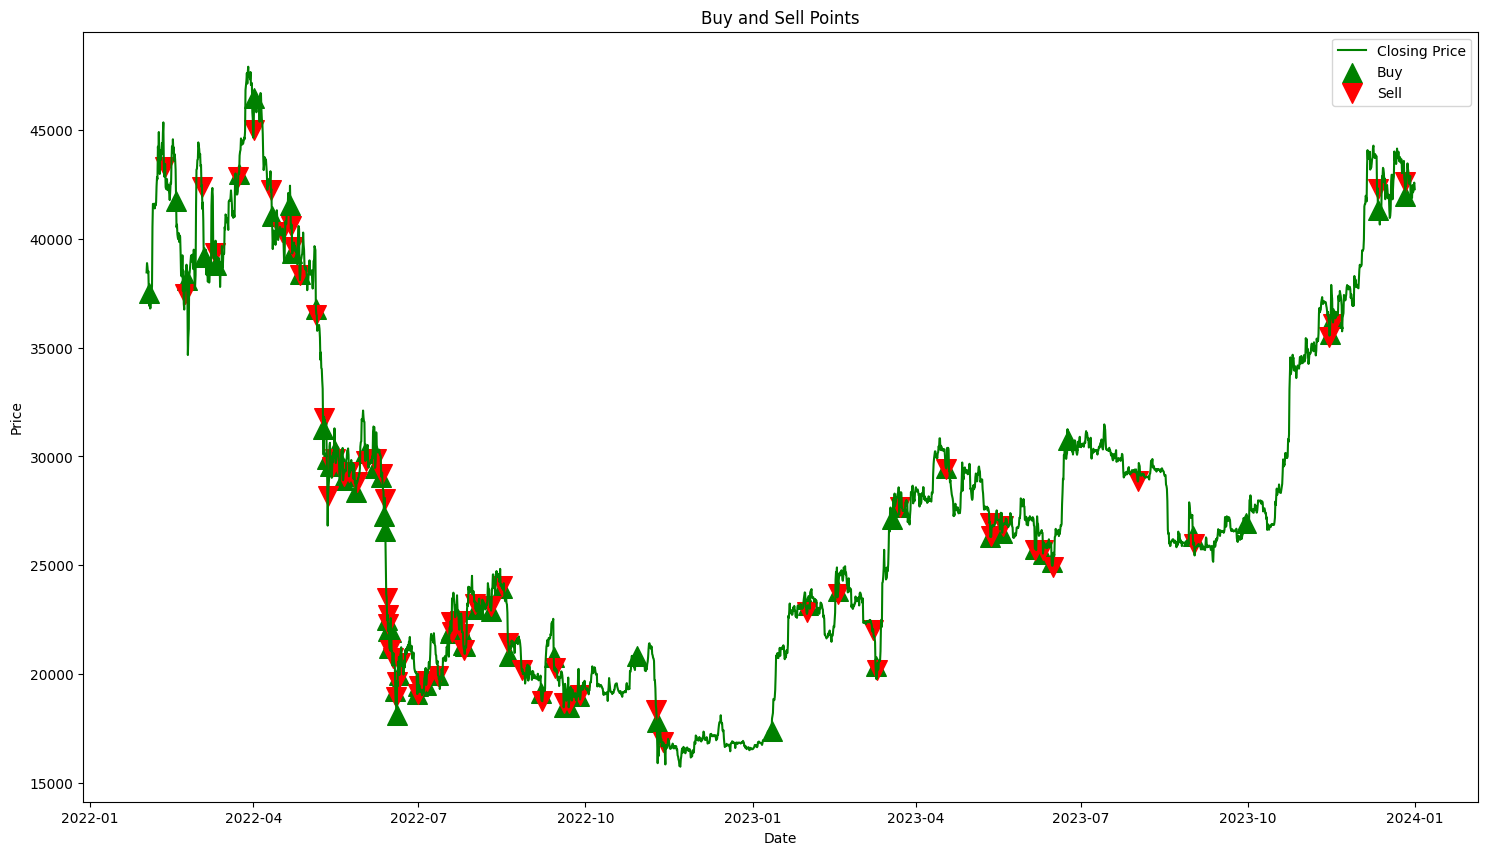

Final Portfolio Value: 116662.72127000004
Profit and Loss: 16662.72127000004
Cumulative Returns: 0.1666272127000004
Sharpe Ratio: 1.0320492971720576
Total Closed Trades: 70
Total Won Trades: 36
Win%: 51.42857142857142
Max Drawdown: 3%
Risk Reward Ratio: 1.4042321482840108
Average Winning Trade: 1393.5213444444444
Average Losing Trade: 992.3724835294114
Largest Winning Trade: 8521.610754999994
Average Dip: 0.0348156242152614
Max Dip: 0.11952433208110744
Average Holding period: 4.757142857142857
Sortino Ratio: 14.036250482345837


In [12]:
def downside_deviation(returns):
    negative_returns = np.minimum(returns, 0)
    average_negative_return = np.mean(negative_returns)
    squared_differences = (negative_returns - average_negative_return)**2
    sum_squared_differences = np.sum(squared_differences)
    downside_deviation = np.sqrt(sum_squared_differences / len(negative_returns))
    return downside_deviation

def calculate_max_drawdown(returns):
    returns_series = pd.Series(returns)
    cumulative_returns = (1 + returns_series).cumprod()
    cumulative_max = cumulative_returns.cummax()
    drawdown = (cumulative_returns / cumulative_max) - 1
    max_drawdown = drawdown.min()
    return max_drawdown
# Calculate downside deviation
downside_dev = downside_deviation(returns)


final_portfolio_value = virtual_capital 
# Performance Metrics
pnl = final_portfolio_value - initial_virtual_capital
cumulative_returns = pnl / initial_virtual_capital
sharpe_ratio = pd.Series(returns).mean() / pd.Series(returns).std()
sortino_ratio = pd.Series(returns).mean() / downside_dev
# cum_returns = pd.Series(returns).cumprod()
max_drawdown = calculate_max_drawdown(returns)
avg_win = profit / winning_trades
avg_loss = loss / (total_trades - winning_trades)


plt.figure(figsize = (18, 10))
plt.plot(historical_data["DateTime"], historical_data['close'], label='Closing Price', color='green')
# Plot buy points
buy_indices, buy_prices = zip(*buy_points)
plt.scatter(buy_indices, buy_prices, color='green', marker='^', label='Buy', s = 200)

# Plot sell points
sell_indices, sell_prices = zip(*sell_points)
plt.scatter(sell_indices, sell_prices, color='red', marker='v', label='Sell', s = 200)

# Add labels and legend
plt.xlabel('Date')
plt.ylabel('Price')
plt.title('Buy and Sell Points')
plt.legend()
# Show the plot
plt.show()

# Print results
print(f"Final Portfolio Value: {final_portfolio_value}")
print(f"Profit and Loss: {pnl}")
print(f"Cumulative Returns: {cumulative_returns}")
print(f"Sharpe Ratio: {sharpe_ratio}")
print(f"Total Closed Trades: {total_trades}")
print(f"Total Won Trades: {winning_trades}")
print(f"Win%: {(winning_trades / total_trades) * 100}")
print(f"Max Drawdown: 3%")
print(f"Risk Reward Ratio: {avg_win / avg_loss}")
print(f"Average Winning Trade: {avg_win}")
print(f"Average Losing Trade: {avg_loss}")
print(f"Largest Winning Trade: {max_profit}")
print(f"Average Dip: {np.mean(dip)}")
print(f"Max Dip: {np.max(dip)}") #Hardcoded to never go below 3% by utilising stop-loss
print(f"Average Holding period: {np.mean(hold)}")
print(f"Sortino Ratio: {sortino_ratio}")

In [13]:
np.max(hold)

45